In [30]:
import pandas as pd
import numpy as np
import gc
from urllib.request import urlopen
from bs4 import BeautifulSoup
import lightgbm as lgb
import matplotlib.pyplot as plt
import math
from util.validation import validation
import util.get_odds as get_odds
validation = validation()

In [2]:
# 確率推定テスト

In [3]:
def softmax(a):
    # 一番大きい値を取得
    c = np.max(a)
    # 各要素から一番大きな値を引く（オーバーフロー対策）
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    # 要素の値/全体の要素の合計
    y = exp_a / sum_exp_a

    return y 

In [4]:
df = pd.read_csv('csv/boat_race_data_tmp.csv')

/Users/yuta_miyawaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,50,86,122) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df = df[df['race_date'] >= 20170000]

In [7]:
PARTS = {'キャリボ': 4,
                 'ピストン': 4,
                 'リング': 3,
                 '電気': 2, 
                 'キャブ': 3,
                 'ギヤ': 2,
                 'シリンダ': 4,
                 'シャフト': 4}
def parts_count(x, key, num):
    x = str(x)
    if x.find(key) != -1:
        if x[x.find(key):].find('×') != -1:
            return x[x.find(key)+num+1]
        else:
            return 1
    else:
        return 0

def drop_miss(df):
    return df[df['is_miss'] == False]

def conv_time(x):
    if str(x).find('nan') != -1:
        return x
    elif str(x).find(':') == -1:
        return np.nan
    else:
        time = x.split(':')
        return float(time[0])*60 + float(time[1]) + float(time[2])/10
        
def preprocessing(df):
    # 月
    df['month'] = df['race_date'].apply(lambda x: (x%10000)//100)
    df['month_old1'] = df['race_date_old1'].apply(lambda x: (x%10000)//100)
    df['month_old2'] = df['race_date_old2'].apply(lambda x: (x%10000)//100)
    df['month_old3'] = df['race_date_old3'].apply(lambda x: (x%10000)//100)
    # 日
    df['date'] = df['race_date'].apply(lambda x: x%100)
    df['date_old1'] = df['race_date_old1'].apply(lambda x: x%100)
    df['date_old2'] = df['race_date_old2'].apply(lambda x: x%100)
    df['date_old3'] = df['race_date_old3'].apply(lambda x: x%100)
    
    # 周期データを三角関数に変換
    # 月
    df['month_cos'] = np.cos(2 * np.pi * df['month']/df['month'].max())
    df['month_sin'] = np.sin(2 * np.pi * df['month']/df['month'].max())
    df['month_cos_old1'] = np.cos(2 * np.pi * df['month_old1']/df['month_old1'].max())
    df['month_sin_old1'] = np.sin(2 * np.pi * df['month_old1']/df['month_old1'].max())
    df['month_cos_old2'] = np.cos(2 * np.pi * df['month_old2']/df['month_old2'].max())
    df['month_sin_old2'] = np.sin(2 * np.pi * df['month_old2']/df['month_old2'].max())
    df['month_cos_old3'] = np.cos(2 * np.pi * df['month_old3']/df['month_old3'].max())
    df['month_sin_old3'] = np.sin(2 * np.pi * df['month_old3']/df['month_old3'].max())
    # 日
    df['date_cos'] = np.cos(2 * np.pi * df['date']/df['date'].max())
    df['date_sin'] = np.sin(2 * np.pi * df['date']/df['date'].max())
    df['date_cos_old1'] = np.cos(2 * np.pi * df['date_old1']/df['date_old1'].max())
    df['date_sin_old1'] = np.sin(2 * np.pi * df['date_old1']/df['date_old1'].max())
    df['date_cos_old2'] = np.cos(2 * np.pi * df['date_old2']/df['date_old2'].max())
    df['date_sin_old2'] = np.sin(2 * np.pi * df['date_old2']/df['date_old2'].max())
    df['date_cos_old3'] = np.cos(2 * np.pi * df['date_old3']/df['date_old3'].max())
    df['date_sin_old3'] = np.sin(2 * np.pi * df['date_old3']/df['date_old3'].max())
    # コース方向
    df['course_direction_cos'] = np.cos(2 * np.pi * df['course_direction']/df['course_direction'].max())
    df['course_direction_sin'] = np.sin(2 * np.pi * df['course_direction']/df['course_direction'].max())
    df['course_direction_cos_old1'] = np.cos(2 * np.pi * df['course_direction_old1']/df['course_direction_old1'].max())
    df['course_direction_sin_old1'] = np.sin(2 * np.pi * df['course_direction_old1']/df['course_direction_old1'].max())
    df['course_direction_cos_old2'] = np.cos(2 * np.pi * df['course_direction_old2']/df['course_direction_old2'].max())
    df['course_direction_sin_old2'] = np.sin(2 * np.pi * df['course_direction_old2']/df['course_direction_old2'].max())
    df['course_direction_cos_old3'] = np.cos(2 * np.pi * df['course_direction_old3']/df['course_direction_old3'].max())
    df['course_direction_sin_old3'] = np.sin(2 * np.pi * df['course_direction_old3']/df['course_direction_old3'].max())
    # 風方向
    df['wind_direction_cos'] = np.cos(2 * np.pi * df['wind_direction']/df['wind_direction'].max())
    df['wind_direction_sin'] = np.sin(2 * np.pi * df['wind_direction']/df['wind_direction'].max())
    df['wind_direction_cos_old1'] = np.cos(2 * np.pi * df['wind_direction_old1']/df['wind_direction_old1'].max())
    df['wind_direction_sin_old1'] = np.sin(2 * np.pi * df['wind_direction_old1']/df['wind_direction_old1'].max())
    df['wind_direction_cos_old2'] = np.cos(2 * np.pi * df['wind_direction_old2']/df['wind_direction_old2'].max())
    df['wind_direction_sin_old2'] = np.sin(2 * np.pi * df['wind_direction_old2']/df['wind_direction_old2'].max())
    df['wind_direction_cos_old3'] = np.cos(2 * np.pi * df['wind_direction_old3']/df['wind_direction_old3'].max())
    df['wind_direction_sin_old3'] = np.sin(2 * np.pi * df['wind_direction_old3']/df['wind_direction_old3'].max())
    # 風とコースの差分方向
    df['course_wind_direction_cos'] = np.cos(2 * np.pi * (df['wind_direction']/df['wind_direction'].max() - df['course_direction']/df['course_direction'].max()))
    df['course_wind_direction_sin'] = np.sin(2 * np.pi * (df['wind_direction']/df['wind_direction'].max() - df['course_direction']/df['course_direction'].max()))
    df['course_wind_direction_cos_old1'] = np.cos(2 * np.pi * (df['wind_direction_old1']/df['wind_direction_old1'].max() - df['course_direction_old1']/df['course_direction_old1'].max()))
    df['course_wind_direction_sin_old1'] = np.sin(2 * np.pi * (df['wind_direction_old1']/df['wind_direction_old1'].max() - df['course_direction_old1']/df['course_direction_old1'].max()))
    df['course_wind_direction_cos_old2'] = np.cos(2 * np.pi * (df['wind_direction_old2']/df['wind_direction_old2'].max() - df['course_direction_old2']/df['course_direction_old2'].max()))
    df['course_wind_direction_sin_old2'] = np.sin(2 * np.pi * (df['wind_direction_old2']/df['wind_direction_old2'].max() - df['course_direction_old2']/df['course_direction_old2'].max()))
    df['course_wind_direction_cos_old3'] = np.cos(2 * np.pi * (df['wind_direction_old3']/df['wind_direction_old3'].max() - df['course_direction_old3']/df['course_direction_old3'].max()))
    df['course_wind_direction_sin_old3'] = np.sin(2 * np.pi * (df['wind_direction_old3']/df['wind_direction_old3'].max() - df['course_direction_old3']/df['course_direction_old3'].max()))
    
    # 展示フライングフラグ
    df['pre_f_flg'] = df['pre_start_timing'].apply(lambda x: str(x).find('F')!=-1)
    df['pre_l_flg'] = df['pre_start_timing'].apply(lambda x: str(x).find('L')!=-1)
    df['pre_start_timing'] = df['pre_start_timing'].apply(lambda x: -1*float(x.replace('F', '0')) if str(x).find('F')!=-1 else (np.nan if str(x).find('L')!=-1 else float(x)))
    df['pre_f_flg_old1'] = df['pre_start_timing_old1'].apply(lambda x: str(x).find('F')!=-1)
    df['pre_l_flg_old1'] = df['pre_start_timing_old1'].apply(lambda x: str(x).find('L')!=-1)
    df['pre_start_timing_old1'] = df['pre_start_timing_old1'].apply(lambda x: -1*float(x.replace('F', '0')) if str(x).find('F')!=-1 else (np.nan if str(x).find('L')!=-1 else float(x)))
    df['start_timing_old1'] = df['start_timing_old1'].apply(lambda x: -1*float(x.replace('F', '0')) if str(x).find('F')!=-1 else (np.nan if str(x).find('L')!=-1 else float(x)))
    df['pre_f_flg_old2'] = df['pre_start_timing_old2'].apply(lambda x: str(x).find('F')!=-1)
    df['pre_l_flg_old2'] = df['pre_start_timing_old2'].apply(lambda x: str(x).find('L')!=-1)
    df['pre_start_timing_old2'] = df['pre_start_timing_old2'].apply(lambda x: -1*float(x.replace('F', '0')) if str(x).find('F')!=-1 else (np.nan if str(x).find('L')!=-1 else float(x)))
    df['start_timing_old2'] = df['start_timing_old2'].apply(lambda x: -1*float(x.replace('F', '0')) if str(x).find('F')!=-1 else (np.nan if str(x).find('L')!=-1 else float(x)))
    df['pre_f_flg_old3'] = df['pre_start_timing_old3'].apply(lambda x: str(x).find('F')!=-1)
    df['pre_l_flg_old3'] = df['pre_start_timing_old3'].apply(lambda x: str(x).find('L')!=-1)
    df['pre_start_timing_old3'] = df['pre_start_timing_old3'].apply(lambda x: -1*float(x.replace('F', '0')) if str(x).find('F')!=-1 else (np.nan if str(x).find('L')!=-1 else float(x)))
    df['start_timing_old3'] = df['start_timing_old3'].apply(lambda x: -1*float(x.replace('F', '0')) if str(x).find('F')!=-1 else (np.nan if str(x).find('L')!=-1 else float(x)))
    
    # パーツフラグと個数
    for key, values in PARTS.items():
        df[key+'_flg'] = df['parts'].apply(lambda x: True if str(x).find(key)!=-1 else False)
        df[key+'_count'] = df['parts'].apply(parts_count, key=key, num=PARTS[key])
        df[key+'_flg_old1'] = df['parts_old1'].apply(lambda x: True if str(x).find(key)!=-1 else False)
        df[key+'_count_old1'] = df['parts_old1'].apply(parts_count, key=key, num=PARTS[key])
        df[key+'_flg_old2'] = df['parts_old2'].apply(lambda x: True if str(x).find(key)!=-1 else False)
        df[key+'_count_old2'] = df['parts_old2'].apply(parts_count, key=key, num=PARTS[key])
        df[key+'_flg_old3'] = df['parts_old3'].apply(lambda x: True if str(x).find(key)!=-1 else False)
        df[key+'_count_old3'] = df['parts_old3'].apply(parts_count, key=key, num=PARTS[key])
        
    # 枠番
    df['bracket_num'] = df['bracket_no']
    df['bracket_num_old1'] = df['bracket_no_old1']
    df['bracket_num_old2'] = df['bracket_no_old2']
    df['bracket_num_old3'] = df['bracket_no_old3']
    
    # 過去レースタイム変換
    df['player_race_time_old1'] = df['player_race_time_old1'].apply(conv_time)
    df['player_race_time_old2'] = df['player_race_time_old2'].apply(conv_time)
    df['player_race_time_old3'] = df['player_race_time_old3'].apply(conv_time)
    
    # 特選フラグ
    #今度つくる
    
    # 前走からの日付
    #コンドツクル
    
    # ターゲットエンコーディング
    group = df.groupby(['bracket_no'])
    # 枠順ごとの着順平均
    df = pd.merge(df, group[['finish_order']].mean().rename(columns={'finish_order': 'finish_order_bracket_mean'}), on='bracket_no')
    # 枠順ごとの着順中央値
    df = pd.merge(df, group[['finish_order']].median().rename(columns={'finish_order': 'finish_order_bracket_mean'}), on='bracket_no')
    
    df = df.sort_values(by=['race_date', 'place_id', 'race_no', 'bracket_no'])
    
    
    # n走前nullフラグ作成
    df['old1_is_null'] = df['race_date_old1'].apply(lambda x: np.isnan(x))
    df['old2_is_null'] = df['race_date_old2'].apply(lambda x: np.isnan(x))
    df['old3_is_null'] = df['race_date_old3'].apply(lambda x: np.isnan(x))
    
    # レース内統計
    group = df.groupby(['race_date', 'place_id', 'race_no'])
    stat_col = [
            'age', 'weight', 'f_count',
            'l_count', 'start_time_avg', 'first_rate_all', 'second_rate_all',
            'third_rate_all', 'first_rate_area', 'second_rate_area',
            'third_rate_area', 'motor_within_second_rate',
            'motor_within_third_rate', 'boat_within_second_rate',
            'boat_within_third_rate', 'pre_time', 'tilt_angle', 'adjust_weight'
            ]
    name_mean = {}
    name_std = {}
    name_max = {}
    name_min = {}
    name_rank = {}
    for c in stat_col:
        name_mean[c] = c + '_mean'
        name_std[c] = c + '_std'
        name_max[c] = c + '_max'
        name_min[c] = c + '_min'
    
    mean_data = group[stat_col].mean()
    std_data = group[stat_col].std()
    max_data = group[stat_col].max()
    min_data = group[stat_col].min()
    
    mean_data = mean_data.rename(columns = name_mean)
    std_data = std_data.rename(columns = name_std)
    max_data = max_data.rename(columns = name_max)
    min_data = min_data.rename(columns = name_min)
    
    df = pd.merge(df, mean_data, on = ['race_date', 'place_id','race_no'])
    df = pd.merge(df, std_data, on = ['race_date', 'place_id','race_no'])
    df = pd.merge(df, max_data, on = ['race_date', 'place_id','race_no'])
    df = pd.merge(df, min_data, on = ['race_date', 'place_id','race_no'])
    
    # ランキング
    group = df.groupby(['race_date', 'place_id', 'race_no'])
    rank_col = [
            'age', 'weight', 'start_time_avg', 'first_rate_all', 'second_rate_all',
            'third_rate_all', 'first_rate_area', 'second_rate_area',
            'third_rate_area', 'motor_within_second_rate',
            'motor_within_third_rate', 'boat_within_second_rate',
            'boat_within_third_rate', 'pre_time'
            ]
    for c in stat_col:
        name_rank[c] = c + '_rank'
    rank_data = group[rank_col].rank(ascending=True,method="first")
    rank_data = rank_data.rename(columns = name_rank)
    df = pd.concat([df, rank_data], axis = 1)
    
    # レース情報
    race_list = df[['race_date', 'place_id', 'race_no', 'bracket_no']]
    
    #One-Hot Encoding
    dummies_list = ['place_id','bracket_no','player_grade','branch','born_area','propeller','weather']
    past_dummies_list = ['place_id','bracket_no','player_grade','branch','born_area','propeller','weather','win_pattern']
    
    for c in past_dummies_list:
        for i in range(3):
            dummies_list.append(c+'_old'+str(i+1))
    for i in range(3):
        dummies_list.append('old'+str(i+1)+'_is_null')
    for key in PARTS.keys():
        dummies_list.append(key+'_flg')
        
    df = pd.get_dummies(data = df, columns = dummies_list)
    
    # 目的変数の抽出
    target = {}
    target['finish_order'] = df['finish_order']
    target['player_race_time'] = df['player_race_time']
    
    # 不要カラムの削除
    drop_list = ['race_date','race_date_no','is_miss','player_id','parts','parts_old1','parts_old2','parts_old3',
                        'motor_no','boat_no','finish_order','player_race_time','race_grade',
                        'start_timing','win_pattern','race_date_old1',
                        'is_miss_old1','player_id_old1','motor_no_old1',
                        'boat_no_old1','race_date_old2','is_miss_old2',
                        'player_id_old2','motor_no_old2','boat_no_old2',
                        'race_date_old3','is_miss_old3','player_id_old3',
                        'motor_no_old3','boat_no_old3',
                        'race_grade_old1', 'race_grade_old2', 'race_grade_old3']
    df.drop(drop_list, axis = 1, inplace=True)
    
    return [df, target, race_list]

In [8]:
df = drop_miss(df)
df, target, race_list = preprocessing(df)

In [9]:
race_list = race_list.reset_index(drop=True)
test_index = race_list[race_list['race_date']>=20190901].index

In [10]:
##### 目的変数作成 #####
# 検証用
val_target_order = target['finish_order'][test_index].values
val_target_first = target['finish_order'][test_index].apply(lambda x: 1 if x == 1 else 0).values
val_target_within_second = target['finish_order'][test_index].apply(lambda x: 0 if x > 2 or np.isnan(x) else 1).values
val_target_within_third = target['finish_order'][test_index].apply(lambda x: 0 if x > 3 or np.isnan(x) else 1).values

In [11]:
# 検証用
val_data = df.values[test_index]
del df
del target
gc.collect()
race_list = race_list.iloc[test_index].reset_index(drop=True)

In [14]:
first_model = lgb.Booster(model_file='model/first_model_target.txt')
# second_model = lgb.Booster(model_file='model/second_model.txt')
# third_model = lgb.Booster(model_file='model/third_model.txt')

In [15]:
output_first = first_model.predict(val_data)
# output_second = second_model.predict(val_data)
# output_third = third_model.predict(val_data)

In [42]:
count = 0
result = []
for x, race in race_list.groupby(['race_date','place_id','race_no']):
    out_first = output_first[race.index][:,1]/sum(output_first[race.index][:,1])
    out_second = (2*output_second[race.index][:,1]/sum(output_second[race.index][:,1])) - out_first
    out_third = (2*output_third[race.index][:,1]/sum(output_third[race.index][:,1])) - out_second
#     print(x)
#     print(race)
#     print(out_first)
#     print(out_second)
#     print(out_third)
    bet = {}
    bet['race_date'] = x[0]
    bet['place_id'] = x[1]
    bet['race_no'] = x[2]
    bet['bet_type'] = 1
    bet['bracket2'] = 0
    bet['bracket3'] = 0
    bet['amount'] = 1
    for i, num in enumerate(race['bracket_no'].values):
        bet['bracket1'] = num
#         print(validation.betting(bet))
        result.append([out_first[i], validation.betting(bet)[1] > 0])
 

(20190901, 5, 1)
   race_date  place_id  race_no  bracket_no
0   20190901         5        1           1
1   20190901         5        1           2
2   20190901         5        1           3
3   20190901         5        1           4
4   20190901         5        1           5
5   20190901         5        1           6
[0.54519085 0.02481643 0.06787497 0.2480423  0.10281216 0.01126329]
(20190901, 5, 1)
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=1&jcd=05&hd=20190901
{'1': 1.3, '2': 25.2, '3': 9.6, '4': 4.4, '5': 6.5, '6': 22.4}
(20190901, 5, 2)
    race_date  place_id  race_no  bracket_no
6    20190901         5        2           1
7    20190901         5        2           2
8    20190901         5        2           3
9    20190901         5        2           4
10   20190901         5        2           5
11   20190901         5        2           6
[0.53322778 0.03335509 0.29061266 0.0736675  0.04798164 0.02115532]
(20190901, 5, 2)
https://www.boatrace.jp/owpc/pc/race/odds

In [81]:
def get_odds_win(soup):
    odds = {}
    rows = soup.find_all('table', {'class': 'is-w495'})[0].find_all('tbody')
    for row in rows:
        cell = row.find_all('td')
        if cell[2].get_text() != '欠場':
            odds[cell[0].get_text()] = float(cell[2].get_text())
    return odds


In [86]:
count = 0
result = []
buy_sum = 0
pay_sum = 0

ex_return = 3000

for x, race in race_list.groupby(['race_date','place_id','race_no']):
    out_first = output_first[race.index][:,1]/sum(output_first[race.index][:,1])
#     out_second = (2*output_second[race.index][:,1]/sum(output_second[race.index][:,1])) - out_first
#     out_third = (2*output_third[race.index][:,1]/sum(output_third[race.index][:,1])) - out_second
    print(x)
#     print(race)
    print(out_first)
    
    url = 'https://www.boatrace.jp/owpc/pc/race/oddstf?rno={race_no}&jcd={place_no}&hd={race_date}'
    url = url.format(**{'race_date': x[0] ,'place_no': "{0:02d}".format(x[1]), 'race_no': x[2]})
    print(url)
    html = urlopen(url)
    soup = BeautifulSoup(html,"html.parser")
#     odds_win = get_odds.get_odds_win(soup)
    odds_win = get_odds_win(soup)
    
    ex_value = {}
    for pred, odds in zip(out_first, odds_win.items()):
        ex_value[odds[0]] = pred*odds[1]
        
        if pred*odds[1] >= 1 and pred > 0.02:
            bet = {}
            bet['race_date'] = x[0]
            bet['place_id'] = x[1]
            bet['race_no'] = x[2]
            bet['bet_type'] = 1
            bet['bracket1'] = int(odds[0])
            bet['bracket2'] = 0
            bet['bracket3'] = 0
            bet['amount'] = 1 if ex_return//(odds[1]*100) == 0 else ex_return//(odds[1]*100)
            buy, pay = validation.betting(bet)
            print(buy, pay)
            buy_sum += buy
            pay_sum += pay
    print(buy_sum, pay_sum)
    print(ex_value)
  
   

(20190901, 5, 1)
[0.54519085 0.02481643 0.06787497 0.2480423  0.10281216 0.01126329]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=1&jcd=05&hd=20190901
600.0 0
600.0 0
{'1': 0.7087481103302968, '2': 0.6253739233602874, '3': 0.6515997219309204, '4': 1.0913861130864482, '5': 0.6682790458210254, '6': 0.2522976962430436}
(20190901, 5, 2)
[0.53322778 0.03335509 0.29061266 0.0736675  0.04798164 0.02115532]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=2&jcd=05&hd=20190901
700.0 0
1300.0 0
{'1': 0.7998416722560358, '2': 0.5770430835566899, '3': 1.1043281132831015, '4': 0.33150376639841794, '5': 0.6525503527351378, '6': 0.3659870073349126}
(20190901, 5, 3)
[0.25153333 0.49246978 0.04886046 0.06876549 0.0072001  0.13117084]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=3&jcd=05&hd=20190901
400.0 2880.0
1700.0 2880.0
{'1': 1.8110399564888338, '2': 0.9849395588762005, '3': 0.4641743818445964, '4': 0.7770500762429474, '5': 0.21384286109995565, '6': 0.26234168443765055}
(20190901, 5, 4)
[0.16

300.0 0
300.0 0
400.0 0
100.0 0
11400.0 18810.0
{'1': 0.5411874303206362, '2': 1.2871716847747923, '3': 0.6077792180758692, '4': 1.0840316377052786, '5': 1.1022168121039713, '6': 1.1945793132547218}
(20190901, 9, 3)
[0.34131874 0.27233529 0.02596738 0.03722223 0.18531462 0.13784175]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=3&jcd=09&hd=20190901
600.0 0
12000.0 18810.0
{'1': 1.6724618267439064, '2': 0.5174370526652722, '3': 0.0, '4': 0.8561111922212287, '5': 0.5559438503690158, '6': 0.5927195278766105}
(20190901, 9, 4)
[0.13906236 0.46319889 0.12414076 0.05274878 0.00260576 0.21824346]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=4&jcd=09&hd=20190901
12000.0 18810.0
{'1': 0.4589057742437897, '2': 0.8800778988630275, '3': 0.8317430975764961, '4': 0.7121084646620489, '5': 0.07035540104498507, '6': 0.8293251420848813}
(20190901, 9, 5)
[0.65493683 0.17619255 0.07400308 0.04121999 0.03743041 0.01621713]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=5&jcd=09&hd=20190901
12000.0 188

300.0 0
100 0
18800.0 27460.0
{'1': 0.7181650044899516, '2': 1.6290832239856106, '3': 0.41895903113225674, '4': 2.5617695562130516, '5': 0.360060296200409, '6': 0.29889924446058036}
(20190901, 11, 6)
[0.40494232 0.04782623 0.2458719  0.28833228 0.0116624  0.00136488]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=6&jcd=11&hd=20190901
800.0 0
19600.0 27460.0
{'1': 0.8908731139845952, '2': 0.2008701493238366, '3': 0.6884413070505087, '4': 1.0091629685732981, '5': 0.0, '6': 0.0}
(20190901, 11, 7)
[0.50049928 0.15555252 0.07631174 0.1132695  0.07107817 0.08328878]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=7&jcd=11&hd=20190901
900.0 2790.0
20500.0 30250.0
{'1': 1.5515477685682053, '2': 0.3733260501255919, '3': 0.7860109345548544, '4': 0.577674456588014, '5': 0.44068466672448237, '6': 0.5163904630817453}
(20190901, 11, 8)
[0.20963599 0.39326294 0.02401351 0.28863198 0.07027215 0.01418342]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=8&jcd=11&hd=20190901
100.0 0
20600.0 30250.0
{'1'

1300.0 0
200.0 0
37600.0 53240.0
{'1': 1.1262558891628238, '2': 0.5622986875454655, '3': 0.5710997518028585, '4': 0.4088254404733707, '5': 0.3640628787562625, '6': 1.0372635583978558}
(20190901, 14, 8)
[0.18372247 0.55053452 0.04995227 0.03274337 0.10291278 0.0801346 ]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=8&jcd=14&hd=20190901
1100.0 0
100 0
38800.0 53240.0
{'1': 0.42256168596214555, '2': 1.431389745521582, '3': 0.5095131632876795, '4': 1.0052213274156645, '5': 0.6998068860809418, '6': 0.3045114661109169}
(20190901, 14, 9)
[0.36341636 0.22597145 0.20783451 0.15352563 0.02821179 0.02104025]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=9&jcd=14&hd=20190901
600.0 0
500.0 0
39900.0 53240.0
{'1': 1.6353736276043644, '2': 0.5423314849930914, '3': 1.0599560141929092, '4': 0.6141025313567566, '5': 0.13541659688444632, '6': 0.32401984670531614}
(20190901, 14, 10)
[0.25918231 0.42235998 0.19436459 0.04641525 0.03939939 0.03827848]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=10&j

47300.0 59510.0
{'1': 0.7569706575794282, '2': 0.8511308647794809, '3': 0.5147255881664398, '4': 0.9085157813977028, '5': 0.17789142281779133, '6': 0.0}
(20190901, 17, 9)
[0.68067624 0.180988   0.06364568 0.04357582 0.02744454 0.00366972]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=9&jcd=17&hd=20190901
200.0 0
47500.0 59510.0
{'1': 0.6806762432788249, '2': 1.9184727828793486, '3': 0.5409882690855601, '4': 0.9281648844213426, '5': 0.5845687639514142, '6': 0.15669706713696732}
(20190901, 17, 10)
[0.66947189 0.10101325 0.12640972 0.03910148 0.03877567 0.02522799]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=10&jcd=17&hd=20190901
200.0 0
200.0 0
100 0
100.0 0
48100.0 59510.0
{'1': 0.6694718930841226, '2': 1.3333748937093486, '3': 1.5674804823910942, '4': 1.1847748360268089, '5': 1.0275552462974533, '6': 0.6685417790461569}
(20190901, 17, 11)
[0.68855725 0.16349373 0.06343342 0.04144138 0.03403118 0.00904304]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=11&jcd=17&hd=20190901
2000.

58300.0 68370.0
{'1': 0.956803644384066, '2': 0.8804474489427692, '3': 0.5014980129606064, '4': 0.6056376141080132, '5': 0.5355909781366817, '6': 0.3628748781764509}
(20190901, 22, 10)
[0.53424897 0.28830564 0.05094316 0.10057832 0.01658669 0.00933722]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=10&jcd=22&hd=20190901
1500.0 0
59800.0 68370.0
{'1': 1.0150730390074496, '2': 0.49011959433117847, '3': 0.6571667269357927, '4': 0.6437012266573912, '5': 1.0698417021390847, '6': 0.0}
(20190901, 22, 11)
[0.60825875 0.15582189 0.07111673 0.04942459 0.10608875 0.00928929]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=11&jcd=22&hd=20190901
200.0 0
200.0 0
60200.0 68370.0
{'1': 0.6082587541063964, '2': 1.714040785088779, '3': 0.8320657569745435, '4': 0.7710236111590067, '5': 1.1033229711993306, '6': 0.5824383127768459}
(20190901, 22, 12)
[0.73074331 0.09768972 0.07485326 0.04744589 0.02317351 0.02609431]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=12&jcd=22&hd=20190901
2100.0 2940.0
62300

1400.0 2940.0
70100.0 80260.0
{'1': 1.2312253669130286, '2': 0.4895108493651549, '3': 0.609757837020465, '4': 0.47069037782820144, '5': 0.3064189899043549, '6': 0.4245533699475773}
(20190902, 1, 11)
[0.55561004 0.07053982 0.0520408  0.20621224 0.0858259  0.0297712 ]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=11&jcd=01&hd=20190902
900.0 0
100 0
71100.0 80260.0
{'1': 1.7223911103004437, '2': 0.465562819887577, '3': 0.22377544741963662, '4': 0.4124244748600825, '5': 0.738102747201637, '6': 1.2206193324786472}
(20190902, 1, 12)
[0.56323322 0.13705108 0.15472443 0.08298641 0.04519107 0.01681378]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=12&jcd=01&hd=20190902
300.0 0
200.0 2620.0
71600.0 82880.0
{'1': 0.6758798635142034, '2': 0.5344992310194988, '3': 1.4079923396385117, '4': 1.0871219659861768, '5': 0.8857450304656779, '6': 0.319461820009861}
(20190902, 5, 1)
[0.64911188 0.04909982 0.08326406 0.16109111 0.03483592 0.02259721]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=1&jcd=0

200.0 0
80500.0 94030.0
{'1': 0.7246098031324191, '2': 0.40306799020414336, '3': 0.6976465118555699, '4': 0.5486135042780943, '5': 1.1259698031632017, '6': 0.31036254469602437}
(20190902, 7, 12)
[0.71289186 0.11106824 0.04310628 0.09119068 0.02577213 0.01597081]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=12&jcd=07&hd=20190902
80500.0 94030.0
{'1': 0.8554702377401253, '2': 0.6441957740635201, '3': 0.5258965935497313, '4': 0.6292157068727675, '5': 0.502556557745942, '6': 0.2970570069880133}
(20190902, 8, 1)
[0.55502052 0.07982075 0.16131049 0.09260425 0.08771268 0.02353131]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=1&jcd=08&hd=20190902
80500.0 94030.0
{'1': 0.888032839005144, '2': 0.7423329388327848, '3': 0.4678004191807744, '4': 0.6111880402189613, '5': 0.9122118603210058, '6': 0.7341769575818529}
(20190902, 8, 2)
[0.33130678 0.27536016 0.14802172 0.08788972 0.14485191 0.01256972]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=2&jcd=08&hd=20190902
500.0 0
200.0 0
300.0 0
815

100 0
89800.0 102240.0
{'1': 0.6990876892806152, '2': 0.6399423765273793, '3': 0.8377798202788979, '4': 2.483957048790482, '5': 0.8200568477250347, '6': 0.09907918980486653}
(20190902, 10, 2)
[0.52617397 0.26194442 0.0355257  0.11222153 0.05315651 0.01097788]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=2&jcd=10&hd=20190902
100 0
89900.0 102240.0
{'1': 0.7892609593266751, '2': 0.6286666011571062, '3': 1.7585219455334373, '4': 0.7855506837202965, '5': 0.489039854636017, '6': 0.8145588379400921}
(20190902, 10, 3)
[0.42319528 0.25621649 0.27095862 0.03771111 0.00748733 0.00443118]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=3&jcd=10&hd=20190902
400.0 2520.0
90300.0 104760.0
{'1': 0.6771124425652966, '2': 1.614163870918722, '3': 0.6773965420039221, '4': 0.5543532458115258, '5': 0.49641029087162664, '6': 0.048742972151629385}
(20190902, 10, 4)
[0.52163202 0.21940112 0.11859169 0.08822382 0.03583653 0.01631481]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=4&jcd=10&hd=20190902
1400.

1000.0 0
300.0 0
104400.0 127420.0
{'1': 1.1901791049003172, '2': 0.7104032672684789, '3': 0.5521162337106451, '4': 0.36474368680333513, '5': 1.301047140197289, '6': 0.2513883543697834}
(20190902, 13, 3)
[0.20177794 0.17896222 0.20597973 0.0119358  0.21881447 0.18252984]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=3&jcd=13&hd=20190902
200.0 0
200.0 0
400.0 2720.0
200.0 0
105400.0 130140.0
{'1': 2.280090769699706, '2': 2.022273074540027, '3': 0.22657770194473933, '4': 0.814021403710145, '5': 1.4879383736630962, '6': 2.0625872296148837}
(20190902, 13, 4)
[0.54304399 0.09744181 0.11641935 0.03855424 0.0992824  0.10525821]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=4&jcd=13&hd=20190902
105400.0 130140.0
{'1': 0.9774791752773233, '2': 0.3605347148265991, '3': 0.4307516051040405, '4': 0.0, '5': 0.36734486178257825, '6': 0.0}
(20190902, 13, 5)
[0.13871339 0.57797883 0.06116063 0.01866986 0.07544186 0.12803543]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=5&jcd=13&hd=20190902
10540

300.0 0
120200.0 138560.0
{'1': 0.8006674210975592, '2': 0.0, '4': 1.4827406937448566, '5': 0.4199251998257567, '6': 0.16638719107862415}
(20190902, 16, 5)
[0.47463561 0.04039513 0.23201672 0.07536848 0.08596701 0.09161704]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=5&jcd=16&hd=20190902
120200.0 138560.0
{'1': 0.901807665213303, '2': 0.39183273304757954, '3': 0.7424535010099489, '4': 0.7310742740266335, '5': 0.833880037407672, '6': 0.4397618137044907}
(20190902, 16, 6)
[0.58735905 0.11012569 0.22444035 0.02710472 0.02809996 0.02287023]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=6&jcd=16&hd=20190902
120200.0 138560.0
{'1': 0.7048308633454686, '2': 0.660754141477514, '3': 0.8753173599064885, '4': 0.8185624975550905, '5': 0.8486188174662239, '6': 0.34534045739481867}
(20190902, 16, 7)
[0.26867169 0.47775847 0.06658853 0.03000833 0.11178373 0.04518924]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=7&jcd=16&hd=20190902
100 0
100.0 0
100 0
120500.0 138560.0
{'1': 0.64481206645911

600.0 0
131300.0 149510.0
{'1': 0.8567052227779859, '2': 0.2871033681418913, '3': 1.5679203366272314, '4': 0.12452897835724092, '5': 0.5620941525577822, '6': 0.9674932870152944}
(20190902, 21, 7)
[0.67545761 0.04804051 0.07320356 0.13298709 0.04754201 0.02276922]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=7&jcd=21&hd=20190902
131300.0 149510.0
{'1': 0.6754576051611914, '2': 0.7446279079073557, '3': 0.9736073440320068, '4': 0.8777148236134243, '5': 0.48968275102515263, '6': 0.7081226113819916}
(20190902, 21, 8)
[0.63509117 0.01550434 0.28783976 0.01225104 0.02379727 0.02551642]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=8&jcd=21&hd=20190902
131300.0 149510.0
{'1': 0.7621094061995932, '2': 0.47443276815597285, '3': 0.8635192746038725, '4': 0.3748817931427931, '5': 0.43549006735290857, '6': 0.4669504989096291}
(20190902, 21, 9)
[0.1928294  0.41944401 0.25256845 0.01849058 0.02156125 0.09510631]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=9&jcd=21&hd=20190902
1200.0 3000.0
50

200.0 0
145400.0 167660.0
{'1': 0.577656248172536, '2': 0.5338446929261272, '3': 0.9546744541238807, '4': 1.2816793686294328, '5': 0.23641180306060874, '6': 0.21256762998199183}
(20190903, 5, 8)
[0.17148296 0.04906384 0.55800243 0.07195352 0.14129279 0.00820446]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=8&jcd=05&hd=20190903
145400.0 167660.0
{'1': 0.9603045798383553, '2': 0.3238213578707907, '3': 0.8370036455804915, '4': 0.5396513891488671, '5': 0.9042738599658062, '6': 0.16408915306221075}
(20190903, 5, 9)
[0.53377199 0.11658883 0.14673651 0.12388734 0.07200275 0.00701256]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=9&jcd=05&hd=20190903
1300.0 2860.0
146700.0 170520.0
{'1': 1.1742983848039013, '2': 0.757827405483215, '3': 0.6603143145654995, '4': 0.45838316256771944, '5': 0.5616214873567051, '6': 0.061710571320522975}
(20190903, 5, 10)
[0.50405802 0.13211385 0.15493975 0.14741475 0.02470494 0.03676869]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=10&jcd=05&hd=20190903
300

100.0 0
163900.0 186790.0
{'1': 0.9261953760709033, '2': 0.7436835567393413, '3': 0.1537258008656693, '4': 1.5254495410598885, '5': 0.6955103822004943, '6': 0.5092562193753836}
(20190903, 7, 9)
[0.64209657 0.11126509 0.06537832 0.03661946 0.12086336 0.0237772 ]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=9&jcd=07&hd=20190903
163900.0 186790.0
{'1': 0.7705158851296198, '2': 0.8122351762439872, '3': 0.8564559682174298, '4': 0.43577155650334787, '5': 0.652662143674883, '6': 0.3899460762028208}
(20190903, 7, 10)
[0.52201739 0.08533673 0.11068697 0.2403134  0.02731847 0.01432703]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=10&jcd=07&hd=20190903
300.0 0
164200.0 186790.0
{'1': 0.9918330419927893, '2': 0.7509632319838618, '3': 1.0847323346242594, '4': 0.4565954603559418, '5': 0.9506828181163246, '6': 0.24929038598136463}
(20190903, 7, 11)
[0.60131141 0.08511819 0.19172993 0.02645324 0.06667717 0.02871005]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=11&jcd=07&hd=20190903
164200.0 1

1100.0 2860.0
100.0 0
100 0
100 0
100 0
178600.0 201030.0
{'1': 1.538512847494651, '2': 0.2198107322387229, '3': 1.6700855587300139, '4': 2.898577353606018, '5': 1.664428613253609, '6': 1.18089071095357}
(20190903, 10, 11)
[0.60669264 0.06231258 0.20958054 0.04625795 0.03504914 0.04010715]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=11&jcd=10&hd=20190903
100.0 0
100 0
178800.0 201030.0
{'1': 0.7887004366847606, '2': 1.1527826527050835, '3': 0.44011913108953993, '4': 1.7161700419198203, '5': 0.0, '6': 0.9906465368698901}
(20190903, 10, 12)
[0.58716943 0.18652389 0.08847261 0.07052837 0.03408963 0.03321607]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=12&jcd=10&hd=20190903
400.0 0
179200.0 201030.0
{'1': 0.7046033125752584, '2': 1.1564480947243518, '3': 0.7874062239628012, '4': 0.39495889004919005, '5': 0.6954284514615962, '6': 0.8470098864234008}
(20190903, 11, 1)
[0.66847778 0.1264888  0.08807929 0.05894183 0.04342571 0.01458659]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=1

193000.0 220310.0
{'1': 0.7561269141788595, '2': 0.581953036612334, '3': 0.5059047007982315, '4': 0.979985802732851, '5': 1.49889533058113, '6': 0.746551537561289}
(20190903, 13, 12)
[0.6182535  0.25600594 0.04001843 0.04960292 0.02786597 0.00825324]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=12&jcd=13&hd=20190903
500.0 2550.0
100.0 0
193600.0 222860.0
{'1': 0.6800788468416397, '2': 1.3056302705162812, '3': 1.00446263778601, '4': 0.4365057231298356, '5': 0.2619401214176023, '6': 0.6214691410540482}
(20190903, 14, 1)
[0.68590539 0.07780299 0.09721851 0.08484375 0.04126341 0.01296595]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=1&jcd=14&hd=20190903
193600.0 222860.0
{'1': 0.7544959262941952, '2': 0.435696756350669, '3': 0.9624632754288683, '4': 0.8399530785322226, '5': 0.5446770268555471, '6': 0.0}
(20190903, 14, 2)
[0.16118454 0.09449967 0.13000164 0.27787068 0.16406986 0.17237362]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=2&jcd=14&hd=20190903
200.0 0
193800.0 222860.0
{'

200.0 0
100.0 0
100.0 0
209200.0 241410.0
{'1': 0.671747460873155, '2': 1.4454603794799932, '3': 0.9511710293360088, '4': 1.6013416555447129, '5': 1.1409116349160742, '6': 0.3019321060776695}
(20190903, 21, 1)
[0.70858073 0.03128299 0.1378742  0.08496372 0.03573475 0.00156362]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=1&jcd=21&hd=20190903
1200.0 3000.0
100 0
210500.0 244410.0
{'1': 1.7714518261979697, '2': 1.3701948716325683, '3': 0.2757483923642903, '4': 0.2548911606748395, '5': 0.3466270599873613, '6': 0.2744147351670726}
(20190903, 21, 2)
[0.63984914 0.03076178 0.06476442 0.24291652 0.01809941 0.00360872]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=2&jcd=21&hd=20190903
100.0 0
210600.0 244410.0
{'1': 0.63984914223688, '2': 0.5813976820418388, '3': 1.2240476267948364, '4': 0.8744994776660193, '5': 0.5484121560920958, '6': 0.0}
(20190903, 21, 3)
[0.58834154 0.01197771 0.19711838 0.0318643  0.16057321 0.01012487]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=3&jcd=21&hd=201

300.0 0
222000.0 254380.0
{'1': 0.7630688566909402, '2': 1.080020074755398, '3': 0.8654877112466474, '4': 0.49422545485781316, '5': 0.9671976649423103, '6': 0.5402261417713478}
(20190904, 4, 2)
[0.49939072 0.07986927 0.22543269 0.10956327 0.05875928 0.02698477]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=2&jcd=04&hd=20190904
1300.0 2990.0
223300.0 257370.0
{'1': 1.1485986467085922, '2': 0.6788888322456824, '3': 0.4734086479783123, '4': 0.5806853287189975, '5': 0.9166447876659551, '6': 0.3615959088096787}
(20190904, 4, 3)
[0.57555885 0.03845697 0.20077835 0.12905857 0.0447517  0.01139557]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=3&jcd=04&hd=20190904
223300.0 257370.0
{'1': 0.7482265063223191, '2': 0.46917503373525815, '3': 0.9035025574907812, '4': 0.6711045663237951, '5': 0.6265237378895652, '6': 0.22335311094688343}
(20190904, 4, 4)
[0.34403314 0.05879675 0.215331   0.26519765 0.1066503  0.00999116]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=4&jcd=04&hd=20190904
500.0 0

600.0 0
100.0 0
241900.0 265550.0
{'1': 0.8329594820249412, '2': 0.5077715434590849, '3': 1.2844638031609157, '4': 0.39097339965962297, '5': 0.8835451613266131, '6': 1.194150937359242}
(20190904, 7, 3)
[0.25059337 0.31353666 0.07087371 0.28685095 0.05021051 0.0279348 ]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=3&jcd=07&hd=20190904
241900.0 265550.0
{'1': 0.7016614298476457, '2': 0.8779026496740626, '3': 0.4110675078749723, '4': 0.9466081260389972, '5': 0.587463019289008, '6': 0.3827067818020919}
(20190904, 7, 4)
[0.33511919 0.3704315  0.20697845 0.07340238 0.00424596 0.00982252]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=4&jcd=07&hd=20190904
241900.0 265550.0
{'1': 0.9718456597990961, '2': 0.9260787467627586, '3': 0.786518094243852, '4': 0.5651983079475388, '5': 0.0445825911548666, '6': 0.08152694662025389}
(20190904, 7, 5)
[0.54979177 0.11030744 0.05539482 0.06854703 0.18686814 0.02909079]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=5&jcd=07&hd=20190904
241900.0 265550.

1700.0 0
250700.0 294560.0
{'1': 1.0603707422738107, '2': 0.5963838534982323, '3': 0.5600819393045471, '4': 0.9514813342937581, '5': 0.8158284746026456, '6': 0.11373632748772902}
(20190904, 13, 4)
[0.41483896 0.23552766 0.20065963 0.11764694 0.02581946 0.00550734]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=4&jcd=13&hd=20190904
250700.0 294560.0
{'1': 0.8296779291224495, '2': 0.7772412776233609, '3': 0.6621767874255794, '4': 0.6470581859697416, '5': 0.42602108340844946, '6': 0.0}
(20190904, 13, 5)
[0.48205831 0.12028146 0.03682481 0.32718292 0.01904203 0.01461047]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=5&jcd=13&hd=20190904
300.0 2700.0
900.0 0
251900.0 297260.0
{'1': 0.5302641413787355, '2': 1.0825331828721252, '3': 0.45662760259972845, '4': 1.079703633842279, '5': 0.0, '6': 0.0}
(20190904, 13, 6)
[0.57119416 0.04463451 0.20663664 0.04324836 0.04944605 0.08484028]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=6&jcd=13&hd=20190904
100 0
252000.0 297260.0
{'1': 0.742552408

100.0 0
300.0 0
200.0 0
100.0 0
263300.0 312760.0
{'1': 0.4666510658861391, '2': 2.992609872821623, '3': 1.8177036158020177, '4': 1.40104099861133, '5': 0.3029353151095451, '6': 1.2248596628927035}
(20190904, 16, 5)
[0.51436995 0.07183506 0.1598569  0.0651624  0.13798801 0.05078768]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=5&jcd=16&hd=20190904
700.0 0
400.0 0
264400.0 312760.0
{'1': 1.954605802667254, '2': 0.301707258809475, '3': 1.007098466780819, '4': 0.0, '5': 0.27597602234689267, '6': 0.2742534663062826}
(20190904, 16, 6)
[0.49035649 0.24964032 0.16771592 0.03674424 0.04533303 0.01021001]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=6&jcd=16&hd=20190904
300.0 0
264700.0 312760.0
{'1': 0.8826416750357501, '2': 2.496403159002207, '3': 0.268345471670456, '4': 0.9810713022022151, '5': 0.0, '6': 0.2726072358311594}
(20190904, 16, 7)
[0.58017055 0.12720236 0.07397224 0.04638885 0.08079451 0.09147148]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=7&jcd=16&hd=20190904
1200.0 0


277100.0 320780.0
{'1': 0.6769602527157229, '2': 0.788831386264352, '3': 0.819144197767875, '4': 0.7712389654945849, '5': 0.5718725736016601, '6': 0.0}
(20190904, 23, 6)
[0.31800747 0.40900632 0.03573834 0.07872149 0.13490463 0.02362175]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=6&jcd=23&hd=20190904
700.0 0
277800.0 320780.0
{'1': 1.208428385370984, '2': 0.5726088506464693, '3': 0.6790284492829364, '4': 0.7006212533538257, '5': 0.8903705697774881, '6': 0.32598012121187464}
(20190904, 23, 7)
[0.38430139 0.24489364 0.25337313 0.02219075 0.05382037 0.04142072]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=7&jcd=23&hd=20190904
800.0 2720.0
600.0 0
279200.0 323500.0
{'1': 1.306624742713713, '2': 0.416319192642518, '3': 1.1908536976610902, '4': 0.28182246481816997, '5': 0.6835187588883479, '6': 0.3934967945375975}
(20190904, 23, 8)
[0.28700161 0.13365956 0.07407802 0.43296337 0.05508785 0.0172096 ]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=8&jcd=23&hd=20190904
1200.0 2880.0
280

1000.0 0
900.0 2790.0
294100.0 347110.0
{'1': 1.152908545228117, '2': 1.033141088838408, '3': 0.6112171669164466, '4': 0.3805482182888722, '5': 0.41219111811509745, '6': 0.31126987972838893}
(20190905, 4, 7)
[0.42504767 0.41129652 0.07026319 0.07049606 0.01285551 0.01004105]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=7&jcd=04&hd=20190905
1100.0 0
295200.0 347110.0
{'1': 1.1051239406070263, '2': 0.6992040787841767, '3': 0.5761581910288066, '4': 0.47232360869912365, '5': 0.21211592491999554, '6': 0.23194820822033552}
(20190905, 4, 8)
[0.46353084 0.23281554 0.044645   0.12108685 0.0120046  0.12591719]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=8&jcd=04&hd=20190905
1100.0 0
296300.0 347110.0
{'1': 1.2051801745163, '2': 0.44234952117641374, '3': 0.9598673997222765, '4': 0.7628471315751891, '5': 0.5173981832477493, '6': 0.566627338572324}
(20190905, 4, 9)
[0.40847032 0.16302821 0.0633801  0.31876618 0.01355815 0.03279704]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=9&jcd=04&hd=

100.0 0
600.0 2700.0
311900.0 371690.0
{'1': 0.6703135923464063, '2': 0.7935247350047229, '3': 1.305186136221272, '4': 0.6556002176890473, '5': 1.146639504748231, '6': 0.07877881606487104}
(20190905, 7, 8)
[0.43481145 0.291157   0.20334723 0.04363908 0.01941504 0.0076302 ]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=8&jcd=07&hd=20190905
311900.0 371690.0
{'1': 0.7391794654323312, '2': 0.6987768070138959, '3': 0.9353972595605383, '4': 0.6327665899995869, '5': 0.6601113076456521, '6': 0.19457017271150948}
(20190905, 7, 9)
[0.69651289 0.08839527 0.03016064 0.05818798 0.09936043 0.02738279]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=9&jcd=07&hd=20190905
200.0 0
312100.0 371690.0
{'1': 0.9054667562962841, '2': 1.149138477248516, '3': 0.21715662776755212, '4': 0.5411481850989631, '5': 0.5166742565284372, '6': 0.4463394684430467}
(20190905, 7, 10)
[0.5945786  0.09620031 0.14619101 0.04141967 0.11364299 0.00796741]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=10&jcd=07&hd=20190905


100.0 0
325500.0 385290.0
{'1': 0.8451219272193181, '2': 0.5718783090027375, '3': 0.6468433298837118, '4': 0.7542547036189543, '5': 1.2810589213892256, '6': 0.5180388077104755}
(20190905, 12, 9)
[0.68559429 0.13122607 0.05236028 0.03812456 0.05600041 0.0366944 ]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=9&jcd=12&hd=20190905
100 0
325600.0 385290.0
{'1': 0.822713143698441, '2': 0.4592912550892296, '3': 0.9110688457284216, '4': 0.7205541483486286, '5': 0.46480337885159967, '6': 1.7026200211534859}
(20190905, 12, 10)
[0.69038335 0.0872804  0.09091094 0.04574941 0.06191511 0.0237608 ]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=10&jcd=12&hd=20190905
200.0 0
200.0 0
326000.0 385290.0
{'1': 0.6903833484963218, '2': 1.230653607946686, '3': 1.3091174783923523, '4': 0.7594401745138721, '5': 0.6191510863316441, '6': 0.4538312998847108}
(20190905, 12, 11)
[0.66875024 0.11701057 0.05829847 0.04527428 0.02191294 0.08875349]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=11&jcd=12&hd=2019

700.0 0
300.0 0
100 0
100 0
342900.0 398630.0
{'1': 0.40709474247311156, '2': 1.2649485574540964, '3': 1.11233135878918, '4': 2.72266292825437, '5': 0.8619700889067758, '6': 1.1016580866614112}
(20190905, 21, 10)
[0.42846343 0.17795039 0.15090648 0.15448001 0.03210097 0.05609873]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=10&jcd=21&hd=20190905
200.0 0
343100.0 398630.0
{'1': 0.5998487987394473, '2': 0.8897519427760892, '3': 1.5241554246993774, '4': 0.8341920309543872, '5': 0.0, '6': 0.3029331357270531}
(20190905, 21, 11)
[0.67808182 0.12346641 0.07955335 0.04248747 0.06970014 0.00671081]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=11&jcd=21&hd=20190905
1600.0 2880.0
100 0
100.0 0
344900.0 401510.0
{'1': 1.2205472789411316, '2': 0.34570594395984666, '3': 0.21479403697979435, '4': 1.3128626866152682, '5': 1.5334031756777882, '6': 1.0368205844214298}
(20190905, 21, 12)
[0.60522315 0.11269902 0.12182818 0.10035131 0.04266666 0.01723168]
https://www.boatrace.jp/owpc/pc/race/oddstf?

200.0 2020.0
358500.0 428180.0
{'1': 0.8614130227126028, '2': 1.1549349156183462, '3': 0.3340976195667689, '4': 0.35971141332492373, '5': 0.5741473521221473, '6': 0.0}
(20190905, 23, 11)
[0.57563911 0.2257922  0.05645159 0.10744111 0.02579483 0.00888116]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=11&jcd=23&hd=20190905
300.0 0
358800.0 428180.0
{'1': 0.6907669342002498, '2': 0.970906465398458, '3': 0.5362900750908796, '4': 1.020690510931949, '5': 0.49010183696409804, '6': 0.253113063448957}
(20190905, 23, 12)
[0.68419802 0.11644187 0.09876774 0.03438294 0.05343583 0.0127736 ]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=12&jcd=23&hd=20190905
100.0 0
358900.0 428180.0
{'1': 0.8210376248300969, '2': 2.1774629792407523, '3': 0.30617999388408434, '4': 0.0, '5': 0.4969532501068075, '6': 0.23886630167129141}
(20190906, 1, 1)
[0.55287282 0.08544189 0.05339909 0.24447922 0.01207383 0.05173314]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=1&jcd=01&hd=20190906
1200.0 2880.0
360100.0 43

200.0 0
368400.0 433620.0
{'1': 0.6864366490715875, '2': 1.0592257758130807, '3': 0.9363656210732139, '4': 0.9037490622907285, '5': 0.5699987936104709, '6': 0.34919508352052403}
(20190906, 6, 1)
[0.5635878  0.24134943 0.08510645 0.04633895 0.03109626 0.03252111]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=1&jcd=06&hd=20190906
600.0 0
369000.0 433620.0
{'1': 0.8453817048742261, '2': 1.0378025602789203, '3': 0.5702132234193522, '4': 0.3938810372032403, '5': 0.28297595433926226, '6': 0.3447237511490685}
(20190906, 6, 2)
[0.45172274 0.11473237 0.05680458 0.05771369 0.25211529 0.06691134]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=2&jcd=06&hd=20190906
600.0 2700.0
100.0 0
369700.0 436320.0
{'1': 0.9486177451488941, '2': 0.28683092205603383, '3': 0.551004406591211, '4': 0.4790236240987726, '5': 1.1345187928416818, '6': 1.953811140985206}
(20190906, 6, 3)
[0.49322785 0.08583733 0.12985619 0.15788057 0.09604545 0.03715262]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=3&jcd=06&hd=20

400.0 0
300.0 0
384700.0 446870.0
{'1': 0.6895829417655387, '2': 0.5333332086265363, '3': 1.0375060377280134, '4': 1.7038758428091332, '5': 0.2944459804785977, '6': 0.06915454875258376}
(20190906, 8, 2)
[0.4515297  0.07718548 0.10731926 0.03923718 0.19158829 0.13314009]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=2&jcd=08&hd=20190906
500.0 0
300.0 0
385500.0 446870.0
{'1': 0.7676004961133159, '2': 0.2778677192503098, '3': 0.7834306087691558, '4': 0.8671416836870253, '5': 1.0537356001801461, '6': 1.1716327582079848}
(20190906, 8, 3)
[0.30612038 0.39464962 0.11830108 0.07393934 0.01073555 0.09625403]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=3&jcd=08&hd=20190906
600.0 0
386100.0 446870.0
{'1': 1.5306018976505942, '2': 0.8287642003546158, '3': 0.5560150660367663, '4': 0.27357556611275147, '5': 0.1309736639621031, '6': 0.837410104101514}
(20190906, 8, 4)
[0.52947212 0.03545312 0.1775506  0.22211923 0.01541585 0.01998907]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=4&jcd=08&hd

100.0 0
401400.0 467250.0
{'1': 0.8596407679373859, '2': 0.9318497300577048, '3': 0.5601713169365682, '4': 1.0748285917258864, '5': 0.518174635715694, '6': 0.1705015003958639}
(20190906, 10, 4)
[0.38563327 0.34438092 0.15611554 0.06111947 0.04032679 0.01242401]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=4&jcd=10&hd=20190906
400.0 0
401800.0 467250.0
{'1': 0.5784499035678272, '2': 0.8265142158639663, '3': 1.1084203210299164, '4': 0.8067770678458498, '5': 0.7500782496997072, '6': 0.5777163278171421}
(20190906, 10, 5)
[0.4037845  0.15422742 0.07902332 0.07426004 0.24093388 0.04777084]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=5&jcd=10&hd=20190906
200.0 0
400.0 0
402400.0 467250.0
{'1': 0.6460552002447923, '2': 0.5552187241357979, '3': 1.0273032185183, '4': 0.4826902422798632, '5': 1.5660702000538578, '6': 0.6210208910016053}
(20190906, 10, 6)
[0.35164036 0.18924515 0.15556567 0.1008849  0.03341394 0.16924998]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=6&jcd=10&hd=20190906


1000.0 2800.0
400.0 0
411800.0 477740.0
{'1': 1.1813332072834484, '2': 0.47038997088361684, '3': 0.322265197343697, '4': 0.5409944964687705, '5': 1.2697701870614737, '6': 0.467349063481371}
(20190906, 17, 5)
[0.64205472 0.06506609 0.13677294 0.13279083 0.01462582 0.0086896 ]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=5&jcd=17&hd=20190906
1800.0 2880.0
200.0 0
413800.0 480620.0
{'1': 1.0272875465449318, '2': 0.16266522871796452, '3': 1.531856917954063, '4': 0.743628654780145, '5': 0.24571384669571278, '6': 0.0}
(20190906, 17, 6)
[0.24892938 0.42678944 0.1858832  0.03224969 0.05060105 0.05554723]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=6&jcd=17&hd=20190906
600.0 2760.0
100 0
100.0 0
100.0 0
414700.0 483380.0
{'1': 1.169968095092364, '2': 0.7682209924761332, '3': 0.37176640394847454, '4': 1.0803647525049134, '5': 1.0170810544207827, '6': 1.3942355793851826}
(20190906, 17, 7)
[0.52315996 0.03692328 0.09291984 0.31919112 0.00412064 0.02368516]
https://www.boatrace.jp/owpc/pc/ra

900.0 0
427900.0 491670.0
{'1': 0.7596405624531041, '2': 0.3158567581671092, '3': 0.6529838832057279, '4': 1.3122615140696172, '5': 0.4802437550080412, '6': 0.677734818403725}
(20190906, 23, 6)
[0.60179235 0.07222085 0.17398488 0.03205393 0.10616873 0.01377925]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=6&jcd=23&hd=20190906
100 0
400.0 2520.0
300.0 0
428700.0 494190.0
{'1': 0.6017923511151922, '2': 2.758836608289259, '3': 1.0961047601605864, '4': 0.30451236182435015, '5': 1.0086029801651468, '6': 0.0}
(20190906, 23, 7)
[0.36482272 0.24980435 0.0430639  0.14831989 0.11229911 0.08169003]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=7&jcd=23&hd=20190906
100 0
428800.0 494190.0
{'1': 0.8026099905749222, '2': 0.8493347850623684, '3': 0.29714092435570716, '4': 0.5487836025549312, '5': 0.673794641001575, '6': 3.9783043132976057}
(20190906, 23, 8)
[0.28192002 0.15617697 0.39892646 0.11530709 0.03158219 0.01608726]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=8&jcd=23&hd=20190906
800

500.0 0
200.0 0
442000.0 514320.0
{'1': 1.79645541762421, '2': 1.1351652419096185, '3': 0.5910935003015565, '4': 0.5430753140655666, '5': 0.20150832383692643, '6': 0.4069120005643536}
(20190907, 5, 7)
[0.60648708 0.14615149 0.06469442 0.07221035 0.08673296 0.0237237 ]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=7&jcd=05&hd=20190907
100.0 0
100.0 0
442200.0 514320.0
{'1': 0.7884332074836606, '2': 0.45306962989088356, '3': 1.332704983445918, '4': 1.4875331711036286, '5': 0.7112102459117808, '6': 0.32501472020308125}
(20190907, 5, 8)
[0.71594711 0.06810145 0.04409194 0.0579403  0.08791686 0.02600236]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=8&jcd=05&hd=20190907
100.0 0
100.0 0
442400.0 514320.0
{'1': 0.7159471070692783, '2': 1.9136506235187154, '3': 0.8245192262924618, '4': 0.8111641875809437, '5': 1.6440451997562555, '6': 0.0}
(20190907, 5, 9)
[0.77744232 0.06875417 0.04717533 0.03216212 0.03893143 0.03553464]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=9&jcd=05&hd=2019090

200.0 0
800.0 0
454800.0 522850.0
{'1': 0.5626980882104424, '2': 0.677273592407091, '3': 1.2911665964196624, '4': 1.0565918549003919, '5': 0.9977049528536662, '6': 0.10636891258679664}
(20190907, 7, 8)
[0.41786452 0.13400906 0.04735866 0.36246976 0.02117512 0.01712288]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=8&jcd=07&hd=20190907
454800.0 522850.0
{'1': 0.793942585188346, '2': 0.9112616265353934, '3': 0.7198516303877625, '4': 0.7249395207993834, '5': 0.3557420466987656, '6': 0.2876643274359767}
(20190907, 7, 9)
[0.65840193 0.15838111 0.06037877 0.04737433 0.02923881 0.04622505]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=9&jcd=07&hd=20190907
400.0 0
455200.0 522850.0
{'1': 0.7242421198430251, '2': 1.0453153038997112, '3': 0.5554847074525848, '4': 0.6253411759108722, '5': 0.5935478790754316, '6': 0.45300549376121624}
(20190907, 7, 10)
[0.66974567 0.10432284 0.05723737 0.07212768 0.07297901 0.02358743]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=10&jcd=07&hd=20190907
45520

300.0 2430.0
100.0 0
200.0 0
462400.0 535890.0
{'1': 0.41161011091742095, '2': 0.8082207504139709, '3': 1.8095248392674603, '4': 1.0276153015771885, '5': 0.9654124797859747, '6': 2.111673105175019}
(20190907, 10, 10)
[0.61063097 0.13181517 0.14162706 0.01717743 0.0848639  0.01388547]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=10&jcd=10&hd=20190907
900.0 0
300.0 2430.0
463600.0 538320.0
{'1': 1.9540190996411875, '2': 1.0677028806199318, '3': 0.26909140489137306, '4': 1.052976524090915, '5': 0.22913253400067307, '6': 0.5956867988070377}
(20190907, 10, 11)
[0.66508925 0.0561664  0.04136679 0.20351411 0.01904641 0.01481705]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=11&jcd=10&hd=20190907
463600.0 538320.0
{'1': 0.73159816996328, '2': 0.8649624847528459, '3': 0.517084899495416, '4': 0.8954620948955802, '5': 0.3466446535796458, '6': 0.2696702279502273}
(20190907, 10, 12)
[0.71907547 0.10069556 0.06889346 0.04620524 0.0563616  0.00876866]
https://www.boatrace.jp/owpc/pc/race/oddstf?

473500.0 558130.0
{'1': 0.8913145122072262, '2': 0.5846306008538633, '3': 0.0, '4': 0.2765419111933519, '5': 0.7258366537751884, '6': 0.9883889785973955}
(20190907, 17, 11)
[0.56454762 0.09566062 0.05276174 0.18380402 0.04850437 0.05472163]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=11&jcd=17&hd=20190907
100.0 0
300.0 0
473900.0 558130.0
{'1': 0.5645476161860143, '2': 0.7461528664854833, '3': 1.4773288301783745, '4': 1.4888125761039315, '5': 0.7324159522323528, '6': 0.826296560631925}
(20190907, 17, 12)
[0.45308208 0.12530344 0.03733406 0.30368191 0.04861824 0.03198026]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=12&jcd=17&hd=20190907
700.0 2660.0
100.0 0
100 0
474800.0 560790.0
{'1': 0.5436984975550326, '2': 0.9648365014203234, '3': 0.7205474334865043, '4': 1.1539912444192706, '5': 1.2494888193042186, '6': 1.2344382146263468}
(20190907, 20, 1)
[0.48003621 0.12107999 0.21241155 0.02364072 0.09405572 0.0687758 ]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=1&jcd=20&hd=201909

488000.0 574500.0
{'1': 0.8787611191997733, '2': 0.2708714689291691, '3': 0.8350794287908836, '4': 0.9711237467564283, '5': 0.23883284176171166, '6': 0.5713624825684017}
(20190907, 22, 12)
[0.58923577 0.11570118 0.08065111 0.17488961 0.0273331  0.01218924]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=12&jcd=22&hd=20190907
100.0 0
100 0
488200.0 574500.0
{'1': 0.5892357685009795, '2': 1.7702279810959016, '3': 0.8549018020276238, '4': 0.8569590932426214, '5': 3.771967217362127, '6': 0.0}
(20190907, 23, 1)
[0.75051104 0.06822709 0.09840924 0.02494913 0.04137132 0.01653218]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=1&jcd=23&hd=20190907
488200.0 574500.0
{'1': 0.8255621489612879, '2': 0.35478084280163186, '3': 0.7872739569355633, '4': 0.3293284713864802, '5': 0.6205698526890145, '6': 0.5323360538641784}
(20190907, 23, 2)
[0.61979776 0.13561738 0.06255428 0.15525353 0.01995521 0.00682184]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=2&jcd=23&hd=20190907
1600.0 2880.0
489800.0 577

200.0 0
200.0 0
100 0
500800.0 585540.0
{'1': 0.5912643435214086, '2': 1.6593271195377717, '3': 0.7935187728312614, '4': 2.8319656308222716, '5': 1.240085021436914, '6': 0.48971203360317034}
(20190908, 5, 1)
[0.56313143 0.03234382 0.06932419 0.30428333 0.02063115 0.01028609]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=1&jcd=05&hd=20190908
1100.0 2860.0
100.0 0
100 0
502100.0 588400.0
{'1': 1.4641417160340333, '2': 0.258750538668395, '3': 1.2963622628691687, '4': 0.39556832457845836, '5': 1.1594708319163045, '6': 0.578078148454466}
(20190908, 5, 2)
[0.20450425 0.25480972 0.09346342 0.08636656 0.04880715 0.31204889]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=2&jcd=05&hd=20190908
200.0 0
600.0 0
502900.0 588400.0
{'1': 0.9816204040475403, '2': 0.3822145738823756, '3': 1.3458732943349536, '4': 0.8809389623883762, '5': 0.58568581241465, '6': 1.4042200231929711}
(20190908, 5, 3)
[0.13397747 0.10491358 0.50492704 0.10681469 0.03338585 0.11598137]
https://www.boatrace.jp/owpc/pc/race/

511700.0 601800.0
{'1': 0.9627459733519502, '2': 0.5127627410653182, '3': 0.7490954686919834, '4': 0.6645653497241731, '5': 0.5091157882553708, '6': 0.2302530181003583}
(20190908, 7, 2)
[0.51500688 0.16493038 0.09667544 0.11428361 0.07495541 0.03414829]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=2&jcd=07&hd=20190908
900.0 2790.0
100 0
512700.0 604590.0
{'1': 1.5965213284100157, '2': 0.7256936614697422, '3': 0.9860895052024211, '4': 0.8228419805750425, '5': 0.1349197312524372, '6': 1.7415625814054614}
(20190908, 7, 3)
[0.39850202 0.35791551 0.114315   0.02317771 0.03445994 0.07162982]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=3&jcd=07&hd=20190908
100.0 0
512800.0 604590.0
{'1': 0.9564048373017252, '2': 0.6800394769072754, '3': 0.4458285089811245, '4': 0.6860600806540144, '5': 0.4066273459858522, '6': 1.4111074144121705}
(20190908, 7, 4)
[0.27126741 0.14127292 0.30497632 0.09617804 0.14268543 0.04361989]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=4&jcd=07&hd=20190908
200.

100.0 0
523800.0 613150.0
{'1': 0.5948168361055063, '2': 0.8699005075218075, '3': 2.0525198813343377, '4': 0.7168482677133765, '5': 0.45153231990516335, '6': 0.156046423993901}
(20190908, 10, 3)
[0.40691799 0.10211229 0.36288528 0.05064363 0.05940528 0.01803553]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=3&jcd=10&hd=20190908
900.0 0
524700.0 613150.0
{'1': 1.3021375674050042, '2': 0.8271095530293232, '3': 0.5080393929041316, '4': 0.850812979660688, '5': 0.4455395646586299, '6': 0.6077974962433438}
(20190908, 10, 4)
[0.38544359 0.34557364 0.09218551 0.13154129 0.03534449 0.00991149]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=4&jcd=10&hd=20190908
524700.0 613150.0
{'1': 0.6937984541883419, '2': 0.7257046393032514, '3': 0.9402921993197922, '4': 0.9865596996901995, '5': 0.40999604718765104, '6': 0.28842426356871004}
(20190908, 10, 5)
[0.32659779 0.06445227 0.44493124 0.09597527 0.02154307 0.04650037]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=5&jcd=10&hd=20190908
200.0 0
524

300.0 0
100.0 0
538100.0 626250.0
{'1': 0.9707591127076645, '2': 0.24569265018447578, '3': 0.6803634344055544, '4': 1.0636985947535518, '5': 0.6713616083222065, '6': 1.509136528741797}
(20190908, 17, 4)
[0.39605387 0.21658202 0.13333777 0.12915182 0.10431256 0.02056196]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=4&jcd=17&hd=20190908
800.0 0
300.0 0
539200.0 626250.0
{'1': 1.3861885553339868, '2': 0.36818943440761864, '3': 0.7066901953017323, '4': 1.0977904327443686, '5': 0.8866567551114464, '6': 0.2919798187564564}
(20190908, 17, 5)
[0.71102917 0.05780616 0.13266102 0.06746643 0.01617758 0.01485964]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=5&jcd=17&hd=20190908
100.0 0
539300.0 626250.0
{'1': 0.711029168793784, '2': 0.8844342045497853, '3': 0.9551593536061035, '4': 1.0322364505169357, '5': 0.3526712234336706, '6': 2.273524764095824}
(20190908, 17, 6)
[0.3716172  0.14111406 0.06461104 0.15878552 0.24950371 0.01436847]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=6&jcd=17&h

500.0 0
551300.0 634890.0
{'1': 0.6346436609996533, '2': 0.5412611365446802, '3': 1.0402189902944625, '4': 0.7445955645641471, '5': 0.0, '6': 0.8597935771733867}
(20190908, 22, 5)
[0.66381826 0.06063142 0.11581943 0.11711636 0.03008929 0.01252524]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=5&jcd=22&hd=20190908
100 0
551400.0 634890.0
{'1': 0.7302000834287108, '2': 0.7760822102168246, '3': 0.6833346559198136, '4': 0.5621585122728909, '5': 2.3228932724245905, '6': 0.9669484230463261}
(20190908, 22, 6)
[0.67661633 0.10429932 0.02491868 0.12725375 0.01496192 0.05195   ]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=6&jcd=22&hd=20190908
2000.0 0
553400.0 634890.0
{'1': 1.0149244906811847, '2': 0.8239646178605712, '3': 0.18689010298362488, '4': 0.5853672650115116, '5': 0.6762787425341444, '6': 0.25975000709439816}
(20190908, 22, 7)
[0.4023292  0.29975334 0.11221569 0.09467951 0.08699972 0.00402255]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=7&jcd=22&hd=20190908
1100.0 0
300.0 279

1000.0 0
100 0
569300.0 645590.0
{'1': 1.3970709176408285, '2': 0.44852385242974924, '3': 0.8018467932378337, '4': 1.5434850854966364, '5': 0.7279577527620209, '6': 0.10809144083134349}
(20190909, 1, 6)
[0.7090672  0.09689956 0.06092715 0.09134152 0.03165114 0.01011343]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=6&jcd=01&hd=20190909
200.0 0
569500.0 645590.0
{'1': 0.7090672025000064, '2': 1.0465152012316028, '3': 0.6580132270951704, '4': 0.9864884170364707, '5': 0.39880440264927797, '6': 0.19114378939028426}
(20190909, 1, 7)
[0.46171781 0.05745094 0.34371901 0.0888893  0.01765856 0.03056439]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=7&jcd=01&hd=20190909
1300.0 2990.0
200.0 0
571000.0 648580.0
{'1': 1.0619509531988922, '2': 0.3906663588293817, '3': 0.6186942237263947, '4': 1.1644498154440903, '5': 0.5562446816589203, '6': 0.2659101559961656}
(20190909, 1, 8)
[0.59244175 0.0704604  0.07772828 0.09204527 0.15763322 0.00969109]
https://www.boatrace.jp/owpc/pc/race/oddstf?rno=8&j

KeyboardInterrupt: 

In [87]:

print(pay_sum, buy_sum)

657470.0 579500.0


In [88]:
print(pay_sum/buy_sum)

1.1345470232959447


In [89]:
pay_sum-buy_sum

77970.0

In [20]:
pred = []
for i in range(100):
    try:
        pred.append(len(list(filter(lambda x: x[0]>=i/100 and x[0]<(i+1)/100 and x[1] == True, result)))/len(list(filter(lambda x: x[0]>=i/100 and x[0]<(i+1)/100, result))))
    except:
        pred.append(0)
    

In [64]:
3000//200

15

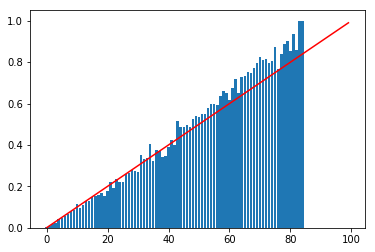

In [22]:
plt.bar([i for i in range(100)], pred)
plt.plot([i/100 for i in range(100)], 'red')

In [23]:
def rmse(target, predicted):
    ar = [(t-p)**2 for t, p in zip(target, predicted)]
    return math.sqrt(sum(ar)/len(ar))

In [112]:
rmse([i/100 for i in range(80)], pred[:80])

0.052012612942059715

In [24]:
rmse([i/100 for i in range(80)], pred[:80])

0.0515010689003215

In [35]:
test_bet = {'race_date': 20190901,
            'place_id': 5,
            'race_no': 1,
            'bet_type': 7,
            'bracket1': 1,
            'bracket2': 3,
            'bracket3': 4,
            'amount': 1
            }

In [36]:
print(validation.betting(test_bet))

[100, 1490.0]


In [37]:
test_bet

{'race_date': 20190901,
 'place_id': 5,
 'race_no': 1,
 'bet_type': 7,
 'bracket1': 1,
 'bracket2': 3,
 'bracket3': 4,
 'amount': 1}